<a href="https://colab.research.google.com/github/Joseperezpar/LSTM_project_2025/blob/main/LSTM_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for hydrological forecasting
## Part 2

This is the continuation of the project. Here we will separate the data in events prepare them to feed the to an LSTM model.

First we will find that **how** we define a model, will impact on the data available and thus in the model performance. So we have just encountered the first set of hyperparameters!
Then we will start building the Model, defining loss metrics and sliding windows to be able to forecast discharge, and tune some other hyperparameters.
Finally, We will train and test de model, and compare it to a discharge from another point of the catchment.

### Datasets


- Crissier precipitation data (mm/day) every 5 min (data log 5 min after measuring) from the 1992-11-30T00:05:00+01:00 to 2021-12-29T16:55:00+01:00.
- WSL* lausannne air temperature (C) mean every 10 min from the 1996-12-10T13:00:00Z to 2025-08-12T16:30:00Z.
- Mèbre aval discharge data (m3/s) every 5 min (data log 5 min after measuring) from the 1992-12-31 23:05:00+00:00 to 2021-01-01 23:00:00+00:00.

- Chamberonne discharge data (m3/s) every 5 min (data log 5 min after measuring) from the 1993-01-01 00:30:00+00:00 to 2021-01-01 23:00:00+00:00.


* *cite

## Importing libraries and setting up the notebook

In [ ]:
# COPY from LSTM notebook

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error

# To make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

In [ ]:
# Google drive data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Division by events for LSTM
Very important! Previously, we only mapped events with rainfall, i.e., where precipitation was not zero, but this meant ignoring dry days when the flow rate was low anyway. Therefore, for this analysis, we will also take into account the zeros (i.e., the initial, unmodified dataset) to capture basin dynamics such as response time.

In [ ]:
#@title Importing data
# Precipitation
dP = pd.read_csv("/content/drive/MyDrive/LSTM_project/crissier_P.csv", delimiter=";", skiprows=1)
dP["date"] = pd.to_datetime(dP["ISO Date"], utc=True, format="ISO8601", errors="coerce")
dP["Pluviometrie [mm/jour]"] = pd.to_numeric(
    dP["Pluviometrie [mm/jour]"], errors="coerce"
).fillna(0)
# We take very two time steps (to match the time resolution of 10 min)
dP2 = dP[1::2].reset_index(drop=True)

# Temperature
dT = pd.read_csv("/content/drive/MyDrive/LSTM_project/WSL_T.csv")
dT["date"] = pd.to_datetime(dT["messtime"], utc=True, format="ISO8601", errors="coerce")
dT.rename(columns={"messval": "temperature"}, inplace=True)

# Discharge
dD = pd.read_csv("/content/drive/MyDrive/LSTM_project/MAV_discharge.csv")
dD["date"] = pd.to_datetime(dD["ISO Date"], utc=True, format="ISO8601", errors="coerce")
dD["Debit [m3/s]"] = pd.to_numeric(
    dD["Debit [m3/s]"], errors="coerce"
).fillna(0)

/tmp/ipython-input-2877577729.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  dP = pd.read_csv("/content/drive/MyDrive/LSTM_project/crissier_P.csv", delimiter=";", skiprows=1)


In [ ]:
# Common dates to join

common_dates = set(dP2["date"]).intersection(dT["date"]).intersection(dD["date"])
common_dates = sorted(list(common_dates))

# mapping with dates
dP2 = dP2[dP2["date"].isin(common_dates)].sort_values("date")
dT = dT[dT["date"].isin(common_dates)].sort_values("date")
dD = dD[dD["date"].isin(common_dates)].sort_values("date")

In [ ]:
# Getting a dataset to separate the data
import pandas as pd

dP2 = dP2.sort_values("date").reset_index(drop=True)
dT = dT.sort_values("date").reset_index(drop=True)
dD = dD.sort_values("date").reset_index(drop=True)

df_all = pd.DataFrame({
    "date": common_dates,
    "precip": dP2["Pluviometrie [mm/jour]"].values,
    "temp": dT["temperature"].values,
    "discharge": dD["Debit [m3/s]"].values
}).set_index("date")

df_all.head()

,precip,temp,discharge
date,,,
1996-12-10 13:00:00+00:00,0.0,-3.22,0.312166
1996-12-10 13:10:00+00:00,0.0,-3.22,0.309794
1996-12-10 13:20:00+00:00,0.0,-3.20,0.307421
1997-01-08 09:00:00+00:00,0.0,-2.70,0.207444
1997-01-21 12:50:00+00:00,0.0,-3.48,1.458979


In [ ]:
df_all.index.year.unique()

Index([1996, 1997, 2002, 2003, 2004, 2005, 2006, 2007, 2012, 2013, 2014, 2015,
       2016, 2017],
      dtype='int32', name='date')

## Exploring the threshold with percentiles

Now that we have a integrated dataset indexed by date, we can start exploring the dataset to find an adequate threshold to separate the events. As we are focusing in a response in discharge from the rain. It will make sense to define events by precipitation and discharge.

### Data statistics
Performing data analysis on the precipitation dataset to find an adequate theshold to latter divide the data. (Hyperparameter)

In [ ]:
df_all.describe()

,precip,temp,discharge
count,547623.000000,547623.000000,547623.000000
mean,0.008106,9.095088,0.338042
std,0.071368,8.093547,0.543408
min,0.000000,-22.410000,0.000000
25%,0.000000,2.758000,0.120054
50%,0.000000,9.100000,0.202159
75%,0.000000,14.970000,0.351600
max,8.588592,100.000000,20.292931


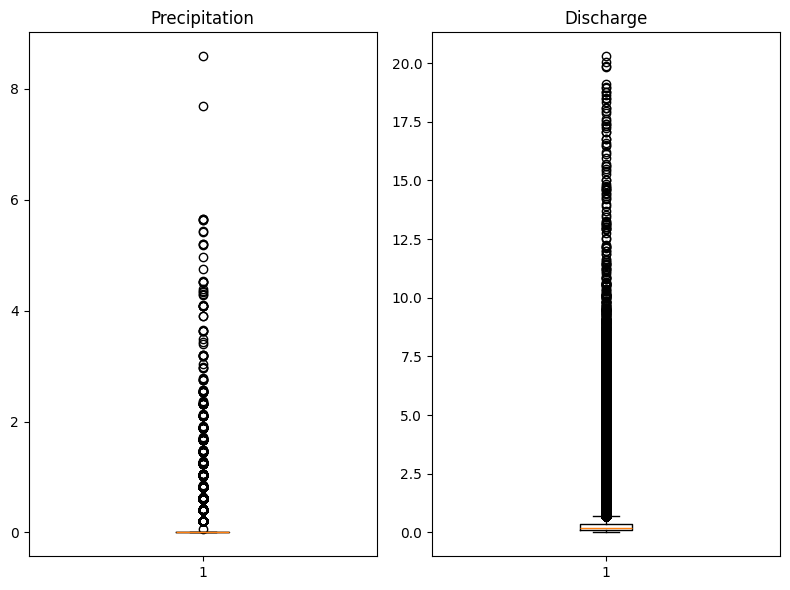

In [ ]:
# Lets plot and see the distribution
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].boxplot(df_all["precip"])
axs[0].set_title("Precipitation")
axs[1].boxplot(df_all["discharge"])
axs[1].set_title("Discharge")

plt.tight_layout()
plt.show()


We see that the events are outliers. and that the mean of the precipitation is 0, not even the P90 is bigger than zero, so we need to focus on the P95,P98 and 99 percentile. As for discharge P95 and P98 is enough.
Indirectly by defining this thresholds we are defining the storms we are looking for, that means a lower percentile in rain and in discharge means a small storm with small response, and as we go higher in the percentiles the more extreme the events.

In [ ]:
import pandas as pd
# Exploring the percentiles
# Percentiles
percentiles = [0.95, 0.98, 0.99]

precip_q = df_all["precip"].quantile(percentiles)
discharge_q = df_all["discharge"].quantile(percentiles)

print("Thresholds precip")
for p, q in precip_q.items():
    print(f"P{p*100:.0f}: {q:.4f}")

print("Thresholds discharge")
for p, q in discharge_q.items():
    print(f"P{p*100:.0f}: {q:.4f}")



Thresholds precip
P95: 0.0000
P98: 0.2040
P99: 0.2040
Thresholds discharge
P95: 1.0213
P98: 1.7281
P99: 2.5024


Now that P95 of Precip is 0, we could only use P98. But we can still use P95 and P98 for discharge.

In [ ]:
# We will set the thresholds here

precip_percentiles = [0.98,0.99]
discharge_percentiles = [0.95, 0.98]

precip_q = df_all["precip"].quantile(precip_percentiles)
discharge_q = df_all["discharge"].quantile(discharge_percentiles)


thresholds = {
    "precip": precip_q.to_dict(),
    "discharge": discharge_q.to_dict()
}



Now that we found some limits, we will create three datasets to train the LSTM model.

### Code to iterate through event separation using the three thresholds.
As we want to have more events, we won't take into account the P99 in discharge.
The following loop will iterate through the dataset and separe the data into events. There are two important points we assume in the code.


*   First is that after an event is defined, we will include the data 24 h before and 48 hour after the event is selected. This is to account for some lags in the hydrology of the catchment as well as the previous conditions of the catchment.
*   Second, to help filter false events, if there are a lot of zeros in the event sample, it will dismiss it.


In [ ]:
# Periods in time
split_time = pd.Timestamp('1996-01-01', tz='UTC')
end_time = pd.Timestamp('2017-12-31', tz='UTC')
valid_period = df_all.loc[split_time:end_time]

# Output folder
base_output = '/content/drive/MyDrive/LSTM_project/events_csv/'
os.makedirs(base_output, exist_ok=True)

# Contador global de eventos
event_counter = 0

# Loop for every threshold
for p_precip, th_precip in precip_q.items():
    for p_discharge, th_discharge in discharge_q.items():

        # Specific folders
        folder_name = f"P{int(p_precip*100)}_precip_P{int(p_discharge*100)}_discharge"
        output_folder = os.path.join(base_output, folder_name)
        os.makedirs(output_folder, exist_ok=True)

        # Mapping events
        event_dates = valid_period[
            (valid_period['precip'] >= th_precip) &
            (valid_period['discharge'] >= th_discharge)
        ].index

        if len(event_dates) == 0:
            print(f"{folder_name}: 0 eventos")
            continue

        #  to deal with contiguous dates
        blocks = []
        start_block = event_dates[0]
        last_time = event_dates[0]

        for t in event_dates[1:]:
            if (t - last_time) > pd.Timedelta(hours=1):  # gap > 1h → new block
                blocks.append((start_block, last_time))
                start_block = t
            last_time = t
        blocks.append((start_block, last_time))

        # Start and end of events (when does it start to take values)
        start_end_events = [(s - pd.Timedelta(hours=24), e + pd.Timedelta(hours=48)) for s, e in blocks]

        # Filter with the "zero" approach
        discharge_col = 'discharge'
        all_events_df = []

        for s, e in start_end_events:
            event_counter += 1
            event_period = df_all.loc[s:e].copy()
            event_period['event_id'] = event_counter  # ID event

            if len(event_period) > 48:
                internal = event_period.iloc[24:-24][discharge_col]
            else:
                internal = event_period[discharge_col]

            zero_ratio = (internal == 0).sum() / len(internal) if len(internal) > 0 else 0
            if zero_ratio <= 0.85:
                if len(event_period) > 2:
                    event_period.iloc[1:-1, event_period.columns.get_loc(discharge_col)] = \
                        event_period.iloc[1:-1, event_period.columns.get_loc(discharge_col)].replace(0, np.nan)

                # Lineal interpolation
                event_period[discharge_col] = event_period[discharge_col].interpolate() # handle zeros that could have been a mistake

                # Saving data
                filename = f"{s.date()}_event.csv"
                filepath = os.path.join(output_folder, filename)
                event_period.to_csv(filepath, index=True)

                # Creates a events dataframe
                all_events_df.append(event_period)

        # creates a global datagrame
        if all_events_df:
            combined_df = pd.concat(all_events_df)
            combined_df.to_csv(os.path.join(output_folder, 'all_events_combined.csv'), index=True)

        # See how many events are at the end
        print(f"{folder_name}: {len(all_events_df)} events")


## LSTM architecture
Usaremos Pythorchs para construir la arquitectura.

Como loss metric usaremos MSE que es mejor para las predicciones de discharge.

Pero para la evaluacion del modelo usaremos NSE.

Hiperparametros en documento word.

Usaremos standard scaler.

Lo hacemos por ahora a un solo paso en el futuro, ya que no tenemos tantos datos.



In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import joblib

In [ ]:
#@title Run this cell to check if a GPU is available. We'll use a variable called `calc_device` to store either the cpu or gpu to run calculations on.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#@title Define the LSTM architecture
class MyLSTM(nn.Module):
    def __init__(self, hidden_size):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM 1 layer, 2 inputs (temp + precip)
        self.LSTM_layer = nn.LSTM(
            input_size=2,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True
        )

        # Linear layer
        self.out_layer = nn.Linear(self.hidden_size, 1)

    def forward(self, X):
        output, (h_n, c_n) = self.LSTM_layer(X)
        hidden_state = h_n[0]  # last layer
        p_hat = self.out_layer(hidden_state)
        return p_hat.squeeze(-1)  # [batch]

In [ ]:
#@title Define NSE calculation function
def calc_nse(sim: torch.FloatTensor, obs: torch.FloatTensor) -> float:
    numerator = torch.square(sim - obs).sum()
    denominator = torch.square(obs - obs.mean()).sum()
    return (1 - numerator/denominator).item()


In [ ]:
#@title Define evaluation function
def eval_model(model, dataloader, loss_func):
    model.eval()
    loss_sum = 0.0
    all_sim, all_obs = [], []

    with torch.no_grad():
        for Xb, yb in dataloader:
            Xb, yb = Xb.float().to(device), yb.float().to(device)
            y_pred = model(Xb)
            loss_sum += loss_func(y_pred, yb).item()
            all_sim.append(y_pred.cpu())
            all_obs.append(yb.cpu())

    all_sim = torch.cat(all_sim, dim=0)
    all_obs = torch.cat(all_obs, dim=0)
    nse = calc_nse(all_sim, all_obs)
    mean_loss = loss_sum / len(dataloader)


    return mean_loss, nse


In [ ]:
#@title First Pipeline for the cvs events files but without the hyperparameter search (so dont run)
# def run_pipeline(csv_path, seq_length=30, hidden_size=32, batch_size=64,
#                  lr=0.001, num_epochs=40):

#     # Csvs
#     df = pd.read_csv(csv_path, parse_dates=['date'], index_col='date')
#     if len(df) < seq_length + 1:
#         return None

#     # Normalize
#     scaler = ColumnTransformer([('scaler', StandardScaler(), ['temp','precip','discharge'])],
#                                remainder='drop')
#     scaled = scaler.fit_transform(df[['temp','precip','discharge']])
#     X_scaled = scaled[:, :2]  # temp + precip
#     y_scaled = scaled[:, 2]   # discharge

#     # Creating the sequences
#     X_seq = np.lib.stride_tricks.sliding_window_view(X_scaled, seq_length, axis=0)[:-1]
#     y_seq = y_scaled[seq_length:]  # next step

#     X_seq = X_seq.reshape(len(X_seq), seq_length, 2)
#     y_seq = y_seq.reshape(-1)

#     # Split 70/15/15
#     n = len(X_seq)
#     train_end = int(0.7*n)
#     val_end = int(0.85*n)
#     X_train, X_val, X_test = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
#     y_train, y_val, y_test = y_seq[:train_end], y_seq[train_end:val_end], y_seq[val_end:]

#     # DataLoaders
#     train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
#                                             torch.tensor(y_train, dtype=torch.float32)),
#                               batch_size=batch_size, shuffle=False)
#     val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
#                                           torch.tensor(y_val, dtype=torch.float32)),
#                             batch_size=batch_size, shuffle=False)
#     test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
#                                            torch.tensor(y_test, dtype=torch.float32)),
#                              batch_size=batch_size, shuffle=False)

#     # Model, loss y optimizer
#     model = MyLSTM(hidden_size=hidden_size).to(device)
#     loss_func = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     # Training
#     best_val_nse = -np.inf
#     train_losses, val_losses, val_NSEs = [], [], []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for Xb, yb in train_loader:
#             Xb, yb = Xb.to(device), yb.to(device)
#             optimizer.zero_grad()
#             y_pred = model(Xb)
#             loss = loss_func(y_pred, yb)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)

#         # Validation
#         val_loss, val_nse = eval_model(model, val_loader, loss_func)
#         val_losses.append(val_loss)
#         val_NSEs.append(val_nse)

#         # Saving best model
#         if val_nse > best_val_nse:
#             best_val_nse = val_nse
#             torch.save(model.state_dict(), 'best_model.pt')

#         print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} "
#               f"| Val Loss: {val_loss:.4f} | Val NSE: {val_nse:.3f}", end="\r")

#     # Evaluation on test
#     model.load_state_dict(torch.load('best_model.pt'))
#     test_loss, test_nse = eval_model(model, test_loader, loss_func)

#     return {
#         'model': model,
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'val_NSEs': val_NSEs,
#         'test_loss': test_loss,
#         'test_NSE': test_nse
#     }

In [ ]:
#@title Run pipeline and model
# base_output = '/content/drive/MyDrive/LSTM_project/events_csv/'

# results = []
# for folder in sorted(os.listdir(base_output)):
#     csv_path = os.path.join(base_output, folder, 'all_events_combined.csv')
#     if os.path.exists(csv_path):
#         print(f"\n🔹 Dataset: {folder}")
#         metrics = run_pipeline(csv_path)
#         if metrics:
#             metrics['dataset'] = folder
#             results.append(metrics)

# # Summary
# summary = pd.DataFrame([{'dataset': r['dataset'], 'test_NSE': r['test_NSE']} for r in results])
# print("\NSE datasest:")
# display(summary)

In [ ]:
#@title Complete model with hyperparameters search for both the model and hydrological parameters (thresholds), the best models are saved, and NSE and MSE are evaluated and visualized according to threshold.
#@markdown We will change between seq_length y hidden_sizes

# code to use GPU if available
if torch.cuda.device_count() > 0:
    calc_device = torch.device('cuda:0')
else:
    calc_device = torch.device('cpu')

In [ ]:
def run_pipeline(csv_path, seq_length=30, hidden_size=32, batch_size=64, lr=0.001, num_epochs=20):

    df = pd.read_csv(csv_path, parse_dates=['date'], index_col='date')
    if len(df) < seq_length + 1:
        return None

    # Normalized
    scaler = ColumnTransformer([('scaler', StandardScaler(), ['temp','precip','discharge'])], remainder='drop')
    scaled = scaler.fit_transform(df[['temp','precip','discharge']])
    X_scaled = scaled[:, :2]
    y_scaled = scaled[:, 2]

    # Sequences creation
    X_seq = np.lib.stride_tricks.sliding_window_view(X_scaled, seq_length, axis=0)[:-1].reshape(len(X_scaled)-seq_length, seq_length, 2)
    y_seq = y_scaled[seq_length:].reshape(-1)

    # Split 70/15/15
    n = len(X_seq)
    train_end = int(0.7 * n)
    val_end = int(0.85 * n)
    X_train, X_val, X_test = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
    y_train, y_val, y_test = y_seq[:train_end], y_seq[train_end:val_end], y_seq[val_end:]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)),
                              batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val,dtype=torch.float32), torch.tensor(y_val,dtype=torch.float32)),
                            batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test,dtype=torch.float32), torch.tensor(y_test,dtype=torch.float32)),
                             batch_size=batch_size, shuffle=False)

    model = MyLSTM(hidden_size=hidden_size).to(calc_device)
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, train_NSEs, val_NSEs = [], [], [], []
    best_val_nse = -np.inf
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(calc_device), yb.to(calc_device)
            optimizer.zero_grad()
            y_pred = model(Xb)
            loss = loss_func(y_pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        train_loss, train_nse  = eval_model(model, train_loader, loss_func)
        val_loss, val_nse = eval_model(model, val_loader, loss_func)

        train_NSEs.append(train_nse)
        val_losses.append(val_loss)
        val_NSEs.append(val_nse)

        if val_nse > best_val_nse:
            best_val_nse = val_nse
            best_model_state = model.state_dict()

    # Evaluation on test
    model.load_state_dict(best_model_state)
    test_loss, test_nse = eval_model(model, test_loader, loss_func)


    # Saving model and scaler
    folder_path = os.path.dirname(csv_path)
    torch.save(best_model_state, os.path.join(folder_path, 'best_model.pt'))
    joblib.dump(scaler, os.path.join(folder_path, 'scaler.save'))

    return {
        'model_state': best_model_state,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_NSEs': val_NSEs,
        'train_NSEs': train_NSEs,
        'test_loss': test_loss,
        'test_NSE': test_nse,
        'scaler': scaler
    }

In [ ]:
# Function to plot learning curves
def plot_learning_curves(train_losses, val_losses, train_NSEs, val_NSEs, save_path, hs, seq_length):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))

    # MSE Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title(f'Loss Curves (HS={hs}, SL={seq_length})')
    plt.legend()

    # NSE
    plt.subplot(1,2,2)
    plt.plot(epochs, train_NSEs, label='Train NSE')
    plt.plot(epochs, val_NSEs, label='Val NSE')
    plt.xlabel('Epochs')
    plt.ylabel('NSE')
    plt.title(f'NSE Curves (HS={hs}, SL={seq_length})')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


# Loop principal
base_output = '/content/drive/MyDrive/LSTM_project/events_csv/'
models_dir = '/content/drive/MyDrive/LSTM_project/best_models/'
os.makedirs(models_dir, exist_ok=True)

summary_list = []

hidden_sizes = [16, 32]
seq_lengths = [24, 48]

for folder in sorted(os.listdir(base_output)):
    csv_path = os.path.join(base_output, folder, 'all_events_combined.csv')
    if not os.path.exists(csv_path):
        continue

    best_val_nse = -np.inf
    best_info = {}

    for hs in hidden_sizes:
        for sl in seq_lengths:
            print(f"Dataset: {folder} | HS: {hs} | SL: {sl}")
            result = run_pipeline(csv_path, hidden_size=hs, seq_length=sl, batch_size=64, num_epochs=10)
            if result is None:
                continue
            if max(result['val_NSEs']) > best_val_nse:
                best_val_nse = max(result['val_NSEs'])
                best_info = {
                    'model_state': result['model_state'],
                    'scaler': result['scaler'],
                    'best_hidden_size': hs,
                    'best_seq_length': sl,
                    'train_losses': result['train_losses'],
                    'val_losses': result['val_losses'],
                    'val_NSEs': result['val_NSEs'],
                    'train_NSEs': result['train_NSEs'],
                    'test_loss': result['test_loss'],
                    'test_NSE': result['test_NSE']
                }

    # Guardar modelo
    model_filename = f"{folder}_HS{best_info['best_hidden_size']}_SL{best_info['best_seq_length']}.pt"
    model_path = os.path.join(models_dir, model_filename)
    torch.save(best_info['model_state'], model_path)

    # Guardar scaler
    scaler_path = os.path.join(models_dir, f"{folder}_scaler.save")
    joblib.dump(best_info['scaler'], scaler_path)

    # Guardar learning curves
    curves_path = os.path.join(models_dir, f"{folder}_learning_curves_HS{best_info['best_hidden_size']}_SL{best_info['best_seq_length']}.png")
    plot_learning_curves(best_info['train_losses'], best_info['val_losses'],
                         best_info['train_NSEs'], best_info['val_NSEs'],
                         curves_path, best_info['best_hidden_size'], best_info['best_seq_length'])

    summary_list.append({
        'dataset': folder,
        'best_hidden_size': best_info['best_hidden_size'],
        'best_seq_length': best_info['best_seq_length'],
        'train_MSE': np.mean(best_info['train_losses']),
        'val_MSE': np.mean(best_info['val_losses']),
        'test_MSE': best_info['test_loss'],
        'train_NSE': np.mean(best_info['train_NSEs']),
        'val_NSE': np.mean(best_info['val_NSEs']),
        'test_NSE': best_info['test_NSE'],
        'model_path': model_path,
        'scaler_path': scaler_path,
        'learning_curves_path': curves_path
    })

summary_df = pd.DataFrame(summary_list)
display(summary_df)

Dataset: P98_precip_P95_discharge | HS: 16 | SL: 24
Dataset: P98_precip_P95_discharge | HS: 16 | SL: 48
Dataset: P98_precip_P95_discharge | HS: 32 | SL: 24
Dataset: P98_precip_P95_discharge | HS: 32 | SL: 48
Dataset: P98_precip_P98_discharge | HS: 16 | SL: 24
Dataset: P98_precip_P98_discharge | HS: 16 | SL: 48
Dataset: P98_precip_P98_discharge | HS: 32 | SL: 24
Dataset: P98_precip_P98_discharge | HS: 32 | SL: 48
Dataset: P99_precip_P95_discharge | HS: 16 | SL: 24
Dataset: P99_precip_P95_discharge | HS: 16 | SL: 48
Dataset: P99_precip_P95_discharge | HS: 32 | SL: 24
Dataset: P99_precip_P95_discharge | HS: 32 | SL: 48
Dataset: P99_precip_P98_discharge | HS: 16 | SL: 24
Dataset: P99_precip_P98_discharge | HS: 16 | SL: 48
Dataset: P99_precip_P98_discharge | HS: 32 | SL: 24
Dataset: P99_precip_P98_discharge | HS: 32 | SL: 48


,dataset,best_hidden_size,best_seq_length,train_MSE,val_MSE,test_MSE,train_NSE,val_NSE,test_NSE,model_path,scaler_path,learning_curves_path
0,P98_precip_P95_discharge,32,48,0.323958,0.802307,0.707377,0.246289,0.385724,0.417183,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...
1,P98_precip_P98_discharge,32,48,0.359340,0.764774,0.463613,0.540414,0.419585,0.561610,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...
2,P99_precip_P95_discharge,32,48,0.319945,0.687021,0.510478,0.330314,0.336267,0.528374,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...
3,P99_precip_P98_discharge,16,48,0.333740,0.679393,0.390691,0.591839,0.378103,0.541618,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...,/content/drive/MyDrive/LSTM_project/best_model...


In [ ]:
n_datasets = len(summary_df)
test_NSEs = summary_df['test_NSE'].values
test_MSEs = summary_df['test_MSE'].values
datasets_names = summary_df['dataset'].values

x = range(n_datasets)
fig, ax1 = plt.subplots(figsize=(12,6), dpi=150)

ax1.set_xlabel('Dataset')
ax1.set_ylabel('Test NSE', color='tab:orange')
ax1.bar(x, test_NSEs, color='tab:orange', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets_names, rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Test MSE', color='tab:blue')
ax2.plot(x, test_MSEs, color='tab:blue', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title("Comparación de rendimiento en Test por Dataset")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import joblib
import pandas as pd

# FIgure with results Predicted vs Observed
fig, axes = plt.subplots(2, 2, figsize=(20, 10), dpi=150)
axes = axes.flatten()

for i, row in enumerate(summary_list[:4]):
    csv_path = os.path.join(base_output, row['dataset'], 'all_events_combined.csv')
    df = pd.read_csv(csv_path, parse_dates=['date'], index_col='date')

    scaler = joblib.load(row['scaler_path'])
    runoff_mean = scaler.named_transformers_['scaler'].mean_[2]
    runoff_std  = np.sqrt(scaler.named_transformers_['scaler'].var_[2])

    X_scaled = scaler.transform(df[['temp','precip','discharge']])[:, :2]
    y_scaled = scaler.transform(df[['temp','precip','discharge']])[:, 2]

    seq_length = row['best_seq_length']
    X_seq = np.lib.stride_tricks.sliding_window_view(
        X_scaled, seq_length, axis=0
    )[:-1].reshape(len(X_scaled)-seq_length, seq_length, 2)
    y_seq = y_scaled[seq_length:].reshape(-1)

    # Test split
    n = len(X_seq)
    val_end = int(0.85 * n)
    X_test = X_seq[val_end:]
    y_test = y_seq[val_end:]
    test_index = df.index[seq_length + val_end : seq_length + n]

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(calc_device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(calc_device)

    model = MyLSTM(hidden_size=row['best_hidden_size']).to(calc_device)
    model.load_state_dict(torch.load(row['model_path']))
    model.eval()

    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred_denorm = y_pred.cpu() * runoff_std + runoff_mean
        y_test_denorm = y_test_tensor.cpu() * runoff_std + runoff_mean

    ax = axes[i]
    ax.plot(test_index, y_test_denorm.numpy(), c='teal', linewidth=1, label='Observed')
    ax.plot(test_index, y_pred_denorm.numpy(), c='orange', alpha=0.85, linewidth=1, label='Predicted')
    ax.axhline(y_test_denorm.mean().item(), color='teal', alpha=0.5, linestyle='--', label='Obs. Mean')
    ax.set_title(f"{row['dataset']} | Predicted vs Observed", size=12)
    ax.set_ylabel("Discharge (mm/h)")
    ax.legend(fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.5)

fig.tight_layout()
fig.set_facecolor('lightgrey')
fig.savefig("sim_vs_obs")
plt.show()


In [ ]:
display(summary_df[['dataset', 'test_NSE', 'test_MSE']])


# Lets test for robutness!
We will use the Chamberonne discharge data.

In [ ]:
#@title Preparing the Chamberonne discharge data
# Importing discharge data
# Discharge
dDCh = pd.read_csv("/content/drive/MyDrive/LSTM_project/CHB_discharge.csv")
dDCh["date"] = pd.to_datetime(dDCh["ISO Date"], utc=True, format="ISO8601", errors="coerce")

# reeplace NAN for 0
dDCh["Debit [m3/s]"] = pd.to_numeric(
    dDCh["Debit [m3/s]"], errors="coerce"
).fillna(0)

In [ ]:
# Intersección de fechas comunes
common_dates = set(dP2["date"]).intersection(dT["date"]).intersection(dDCh["date"])
common_dates = sorted(list(common_dates))

# Filtrar todas con esas fechas
dP2 = dP2[dP2["date"].isin(common_dates)].sort_values("date")
dT = dT[dT["date"].isin(common_dates)].sort_values("date")
dDCh = dDCh[dDCh["date"].isin(common_dates)].sort_values("date")

In [ ]:
df_chb = pd.DataFrame({
    "date": common_dates,
    "precip": dP2["Pluviometrie [mm/jour]"].values,
    "temp": dT["temperature"].values,
    "discharge": dDCh["Debit [m3/s]"].values
}).set_index("date")


In [ ]:
df_chb.index.year.unique()

In [ ]:
import re
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

models_dir = '/content/drive/MyDrive/LSTM_project/best_models/'

results = []

for model_file in sorted(os.listdir(models_dir)):
    if model_file.endswith('.pt') and 'HS' in model_file and 'SL' in model_file:

        m = re.match(r"(.+)_HS(\d+)_SL(\d+)\.pt", model_file)
        if m:
            dataset_name, hidden_size, seq_length = m.groups()
            hidden_size = int(hidden_size)
            seq_length = int(seq_length)

            model_path = os.path.join(models_dir, model_file)
            scaler_path = os.path.join(models_dir, f"{dataset_name}_scaler.save")

            # Load model
            model = MyLSTM(hidden_size=hidden_size).to(calc_device)
            model.load_state_dict(torch.load(model_path))
            model.eval()
            scaler = joblib.load(scaler_path)

            # Scale dataset
            scaled = scaler.transform(df_chb[['temp','precip','discharge']])
            X_scaled = scaled[:, :2]
            y_scaled = scaled[:, 2]

            X_seq = np.lib.stride_tricks.sliding_window_view(
                X_scaled, seq_length, axis=0
            )[:-1].reshape(len(X_scaled)-seq_length, seq_length, 2)
            y_seq = y_scaled[seq_length:].reshape(-1)

            X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(calc_device)
            y_tensor = torch.tensor(y_seq, dtype=torch.float32).to(calc_device)

            with torch.no_grad():
                y_pred_scaled = model(X_tensor)
                runoff_mean = scaler.named_transformers_['scaler'].mean_[2]
                runoff_std = np.sqrt(scaler.named_transformers_['scaler'].var_[2])
                y_pred = y_pred_scaled.cpu() * runoff_std + runoff_mean
                y_obs = y_tensor.cpu() * runoff_std + runoff_mean

            # Performance
            nse_val = calc_nse(y_pred_scaled.cpu(), y_tensor.cpu())
            r2_val = r2_score(y_obs.numpy(), y_pred.numpy())
            mse_val = mean_squared_error(y_obs.numpy(), y_pred.numpy())

            results.append({
                'model_file': model_file,
                'hidden_size': hidden_size,
                'seq_length': seq_length,
                'NSE': nse_val,
                'R2': r2_val,
                'MSE': mse_val
            })

            # Plotting
            fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
            ax.plot(y_obs.numpy(), label='Observed', color='teal', linewidth=1)
            ax.plot(y_pred.numpy(), label='Predicted', color='orange', alpha=0.85, linewidth=1)
            ax.axhline(y_obs.mean().item(), color='gray', linestyle='--', alpha=0.6)
            ax.set_title(f"{dataset_name} | Predicted vs Observed\n"
                         f"NSE={nse_val:.3f}, R²={r2_val:.3f}, MSE={mse_val:.3f}", size=11)
            ax.set_ylabel("Discharge (mm/day)")
            ax.legend()
            fig.set_facecolor('lightgrey')
            plt.show()




In [ ]:
# Figura 2x2 solo con test final (último 15%)
fig, axes = plt.subplots(2, 2, figsize=(20, 10), dpi=150)
axes = axes.flatten()

for i, model_file in enumerate(model_files[:4]):  # los 4 primeros modelos
    dataset_name, hidden_size, seq_length = re.match(r"(.+)_HS(\d+)_SL(\d+)\.pt", model_file).groups()
    hidden_size = int(hidden_size)
    seq_length = int(seq_length)

    model_path = os.path.join(models_dir, model_file)
    scaler_path = os.path.join(models_dir, f"{dataset_name}_scaler.save")

    # Load model and scaler
    model = MyLSTM(hidden_size=hidden_size).to(calc_device)
    model.load_state_dict(torch.load(model_path, map_location=calc_device))
    model.eval()
    scaler = joblib.load(scaler_path)

    # Scale data
    scaled = scaler.transform(df_test[['temp','precip','discharge']])
    X_scaled = scaled[:, :2]
    y_scaled = scaled[:, 2]

    # Create sequences
    X_seq = np.lib.stride_tricks.sliding_window_view(
        X_scaled, seq_length, axis=0
    )[:-1].reshape(len(X_scaled)-seq_length, seq_length, 2)
    y_seq = y_scaled[seq_length:].reshape(-1)

    # --- Temporal test split (último 15%) ---
    n = len(X_seq)
    val_end = int(0.85 * n)
    X_test = X_seq[val_end:]
    y_test = y_seq[val_end:]
    test_index = df_test.index[seq_length + val_end : seq_length + n]

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(calc_device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(calc_device)

    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor)
        runoff_mean = scaler.named_transformers_['scaler'].mean_[2]
        runoff_std  = np.sqrt(scaler.named_transformers_['scaler'].var_[2])
        y_pred = y_pred_scaled.cpu() * runoff_std + runoff_mean
        y_obs  = y_test_tensor.cpu() * runoff_std + runoff_mean

    # Performance metrics
    nse_val = calc_nse(y_pred_scaled.cpu(), y_test_tensor.cpu())
    r2_val  = r2_score(y_obs.numpy(), y_pred.numpy())
    mse_val = mean_squared_error(y_obs.numpy(), y_pred.numpy())

    results.append({
        'dataset': dataset_name,
        'NSE': nse_val,
        'R2': r2_val,
        'MSE': mse_val
    })

    # Plot test only
    ax = axes[i]
    ax.plot(test_index, y_obs.numpy(), c='teal', linewidth=1, label='Observed')
    ax.plot(test_index, y_pred.numpy(), c='orange', alpha=0.85, linewidth=1, label='Predicted')
    ax.axhline(y_obs.mean().item(), color='gray', linestyle='--', alpha=0.6)
    ax.set_title(f"{dataset_name}\nNSE={nse_val:.3f}, R²={r2_val:.3f}, MSE={mse_val:.3f}", size=11)
    ax.set_ylabel("Discharge (mm/day)")
    ax.legend(fontsize=8)
    ax.grid(True, linestyle=':', alpha=0.4)

fig.tight_layout()
fig.set_facecolor('lightgrey')
fig.savefig("sim_vs_obs_test_Chamberonne")
plt.show()

# Tabla de resultados
results_df = pd.DataFrame(results)
display(results_df)

